In [1]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Adjust to your preferred style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
def parse_combined_json(json_path: str):
    """
    Parses a combined.json file, extracting coverage & atomicity from each entry.
    Extracts alignment_method, model, and threshold based on directory structure.
    """
    # 1) Break the path into components
    parts = json_path.split(os.sep)
    
    # 2) Extract relevant directory names
    try:
        alignment_method = parts[-5]  # 'entailment'
        model_dir = parts[-4]  # e.g., 'gpt_maximize_coverage'
        threshold_str = parts[-3]  # e.g., 'threshold_0.70'
        threshold_val = float(threshold_str.replace("threshold_", ""))
    except (IndexError, ValueError):
        print(f"Warning: Could not extract metadata from path {json_path}")
        return []

    # 3) Load the JSON data
    with open(json_path, "r") as f:
        data = json.load(f)
    
    rows = []

    # 4) Process JSON entries
    for dataset_name, entries in data.items():
        if isinstance(entries, list):
            for item in entries:
                coverage = item.get("coverage", None)
                atomicity = item.get("atomicity", None)
                
                row = {
                    "dataset": dataset_name,
                    "alignment_method": alignment_method,
                    "model": model_dir,
                    "threshold": threshold_val,
                    "coverage": coverage,
                    "atomicity": atomicity
                }
                rows.append(row)
    
    return rows

In [5]:
# Define the base path where JSON results are stored
base_path = "../metrics/alignment_results"  # Adjust if needed

all_records = []

# Recursively search for all combined.json files
pattern = os.path.join(base_path, "**", "combined.json")
json_files = glob.glob(pattern, recursive=True)

for jf in json_files:
    records = parse_combined_json(jf)
    all_records.extend(records)

# Convert to DataFrame
df = pd.DataFrame(all_records)

print(f"Found {len(df)} entries total.")
df.head()

Found 20 entries total.


,dataset,alignment_method,model,threshold,coverage,atomicity
0,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,0.666667,0.400000
1,cnndm_validation,roberta-large-mnli,kg_based_claims,0.7,0.777778,0.833333
2,xsum,roberta-large-mnli,kg_based_claims,0.7,0.000000,0.000000
3,samsum,roberta-large-mnli,kg_based_claims,0.7,1.000000,1.000000
4,cnndm_test,roberta-large-mnli,gpt_maximize_coverage,0.7,1.000000,0.375000


In [6]:
# Compute average coverage & atomicity by method, model, threshold
group_cols = ["alignment_method", "model", "threshold"]

summary_df = (
    df.groupby(group_cols, as_index=False)
      .agg({
          "coverage": "mean",
          "atomicity": "mean",
      })
)

summary_df.sort_values(group_cols, inplace=True)
summary_df

,alignment_method,model,threshold,coverage,atomicity
0,roberta-large-mnli,gpt_granularity_high,0.7,0.527778,0.359375
1,roberta-large-mnli,gpt_granularity_low,0.7,0.527778,0.380208
2,roberta-large-mnli,gpt_maximize_atomicity,0.7,0.555556,0.430060
3,roberta-large-mnli,gpt_maximize_coverage,0.7,0.944444,0.666667
4,roberta-large-mnli,kg_based_claims,0.7,0.611111,0.558333


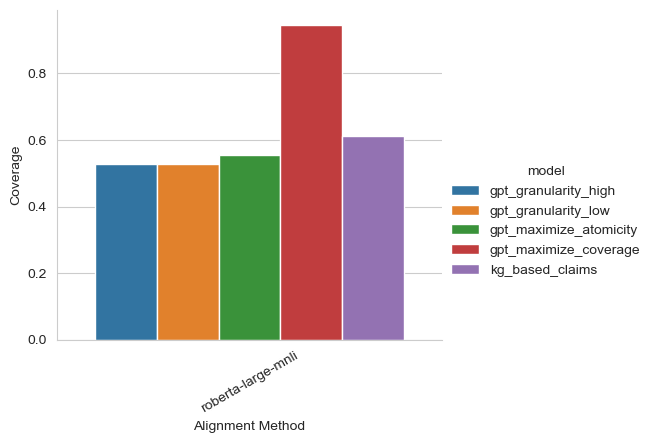

In [7]:
g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="coverage",
    hue="model", 
    # col="threshold",
    height=4, 
    aspect=1.2
)

g.set_titles("Coverage")  
g.set_xlabels("Alignment Method")
g.set_ylabels("Coverage")
g.set_xticklabels(rotation=30)
plt.show()

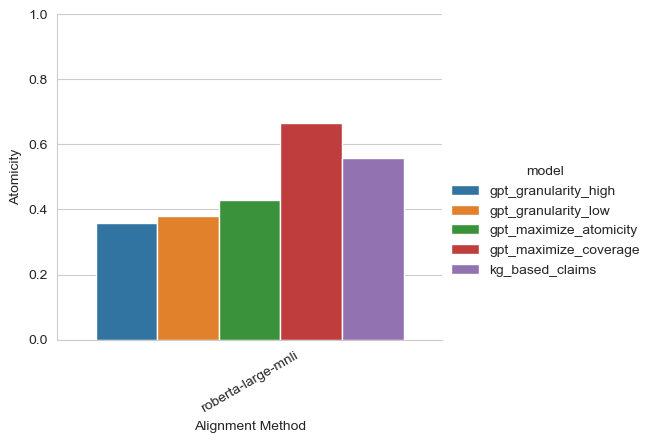

In [8]:
sns.set_style("whitegrid")

g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="atomicity",
    hue="model", 
    # col="threshold",
    height=4, 
    aspect=1.2
)

g.set_titles("Atomicity")
g.set_xlabels("Alignment Method")
g.set_ylabels("Atomicity")
g.set_xticklabels(rotation=30)
g.set(ylim=(0, 1.0))
plt.show()